<img
    style="float:left;width:20%;"
    title="Cardiff University Logo"
    src="https://upload.wikimedia.org/wikipedia/en/b/b1/Cardiff_university_logo.png"
    />

# Media Monitor Analysis

A joint research project between the [School of Computer Science](https://www.cs.cf.ac.uk/) and the [School of Journalism](http://www.cardiff.ac.uk/journalism-media-cultural-studies) at Cardiff University. 

---

*This notebook requires a mongoDB database called **`media-monitor`** with a **`tweets`** collection containing [Tweet objects](https://dev.twitter.com/overview/api/tweets). It aims to analyse the data collected by the [media-monitor](https://github.com/taylorrees/media-monitor) tool.*

## Table of Contents

- [1. Key Terms](#1.-Key-Terms)


- [2. Getting Started](#2.-Getting-Started)


- [3. Distribution Analysis](#3.-Distribution-Analysis)
    - [3.1. Original Tweets](#3.1.-Original-Tweets)
    - [3.2. Retweets](#3.2.-Retweets)
    - [3.3. Replies](#3.3.-Replies)
    - [3.4. Links](#3.4.-Links)
    - [3.5. Hashtags](#3.5.-Hashtags)
    
    
- [4. Network Analysis](#4.-Network-Analysis)
    - [4.1. Mentions](#4.1.-Mentions)
    - [4.2. Replies](#4.2.-Replies)
    
    
- [5. Sentiment Analysis](#5.-Sentiment-Analysis)
    - [5.1. All Tweets](#5.1.-All-Tweets)
    - [5.2. Journalists](#5.2.-Journalists)
    - [5.3. Organisations](#5.3.-Organisations)

---

## 1. Key Terms

**`JOI`** Journalists of interest

**`OOI`** Organisations of interest

**`EXT`** Accounts not followed by streaming api

## 2. Getting Started

To get started you'll need the following packages
- `pymongo`
- `textblob`

To install them run

In [ ]:
%%bash
pip3 install pymongo
pip3 install textblob

Next you'll need to import the dependencies. 

In [35]:
"""Import dependencies"""

from collections import Counter
from IPython.display import display
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np
from db import DB

%matplotlib inline

Now we setup new collections in the database.

We also need to extend the `Collect` class to cater to our needs as we want the store method to clear a specified collection everytime it is called.

_**Note**_

Only call if the journalists and organisations collections are not already setup in the database. This will read the JSON files containing journalist and organisation twitter lists and store them in the appropriate database.

In [ ]:
"""Setup for collection creation"""

from json import load
from collect import Collect

class Collect(Collect):
    def store(self, collection):
        # extend and alter store
        DB[collection].delete_many({})
        DB[collection].insert_many(self.members)

In [ ]:
"""Create database collections"""

# get & store journalists from twitter lists
j = load(open("journalists.json"))
collect = Collect(lists=j)
collect.store("journalists")

# get & store news organisations from twitter lists
o = load(open("organisations.json"))
collect = Collect(lists=o, refine=False, append=True)
collect.store("organisations")

## 3. Distribution Analysis

*A collection of inline visualisations to illustrate the demographics of the data collected.*

In [36]:
"""Setup for distribution analysis"""

journalists = DB.journalists.distinct("id_str")
organisations = DB.organisations.distinct("id_str")
tweets = [tweet for tweet in DB.tweets.find()]

In [37]:
def dist_pie(joi, ooi):
    """Plot a pie chart"""
    
    # calculate mean percentage
    joi_size = len(joi)
    ooi_size = len(ooi)
    total = joi_size + ooi_size

    joi_mean = (joi_size / total) * 100
    ooi_mean = (ooi_size / total) * 100

    # data to plot
    sizes = [joi_mean, ooi_mean]
    labels = "Journalists", "Organisations"
    colors = ['lightskyblue', 'lightcoral']
    
    # plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=90)

    plt.axis('equal')
    plt.show()

In [38]:
def top_10(joi, ooi, label):
    """Plot a bar chart of top 10"""
    
    # create list of users
    id_strs = ["@%s" % tweet["user"]["screen_name"] 
               for tweet in joi]

    id_strs += ["@%s" % tweet["user"]["screen_name"] 
                for tweet in ooi]

    # count occurances
    counter = Counter(id_strs)
    most_common = counter.most_common(10)

    # data to plot
    labels, y = zip(*most_common)
    x = range(len(labels))
    
    # plot
    plt.bar(x, y, alpha=0.5)
    plt.xticks(x, labels, rotation='45')
    plt.ylabel(label)
    plt.show()

In [39]:
def tabulate(headers, data):
    """Output a markdown table"""
    
    # data to output 
    table = " | ".join(headers) + " \n"
    table += " --- | --- \n"

    for row in data:
        table += " | ".join(str(x) for x in row) + " \n"

    # output
    display(Markdown(table))

### 3.1. Original Tweets

This section of the analysis aims to look at the number of original tweets authored throughout the data collection period. An original tweet is one that has been published by a user that is not a reply nor a retweet. We will look for tweets authored by the `JOI`, `OOI` and `EXT` accounts. 

In [40]:
"""Collect the data"""

# get sets of id_str's

joi_originals = [tweet 
                 for tweet in DB.tweets.find({
                     "user.id_str": {"$in": journalists},
                     "in_reply_to_status_id_str": {"$eq": None},
                     "retweeted_status": {"$exists": False}
                 })]

ooi_originals = [tweet
                 for tweet in DB.tweets.find({
                     "user.id_str": {"$in": organisations},
                     "in_reply_to_status_id_str": {"$eq": None},
                     "retweeted_status": {"$exists": False}
                 })]

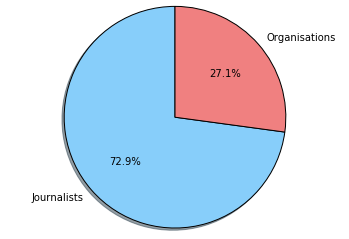

In [41]:
"""Plot a pie chart"""

dist_pie(joi_originals, ooi_originals)

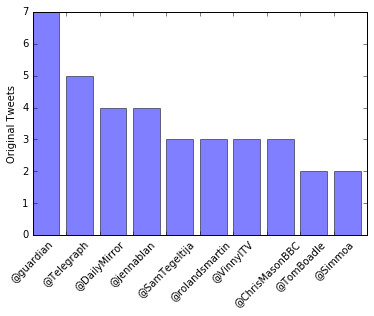

In [42]:
"""Plot top 10"""

top_10(joi_originals, ooi_originals, label="Original Tweets")

### 3.2. Retweets

This section of the analysis aims to look at the number of retweets created throughout the data collection period. 

In [43]:
"""Collect the data"""

# get sets of id_str's

joi_retweets = [tweet
                for tweet in DB.tweets.find({
                    "user.id_str": {"$in": journalists},
                    "retweeted_status": {"$exists": True}
                })]

ooi_retweets = [tweet
                for tweet in DB.tweets.find({
                    "user.id_str": {"$in": organisations},
                    "retweeted_status": {"$exists": True}
                })]

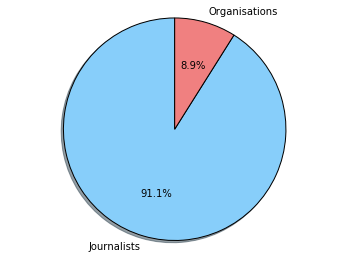

In [44]:
"""Plot a pie chart"""

dist_pie(joi_retweets, ooi_retweets)

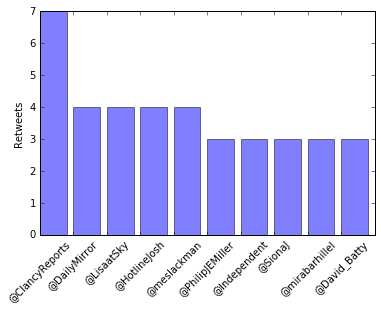

In [45]:
"""Plot top 10"""

top_10(joi_retweets, ooi_retweets, label="Retweets")

### 3.3. Replies

This section of the analysis aims to look at the number of replies authored throughout the data collection period. 

In [46]:
"""Collect the data"""

# get sets of id_str's

joi_replies = [tweet
               for tweet in DB.tweets.find({
                   "user.id_str": {"$in": journalists},
                   "in_reply_to_status_id_str": {"$ne": None}
               })]

ooi_replies = [tweet
               for tweet in DB.tweets.find({
                   "user.id_str": {"$in": organisations},
                   "in_reply_to_status_id_str": {"$ne": None}
               })]

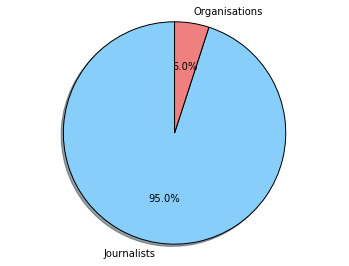

In [47]:
"""Plot a pie chart"""

dist_pie(joi_replies, ooi_replies)

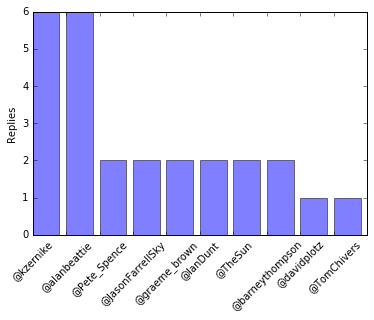

In [48]:
"""Plot top 10"""

top_10(joi_replies, ooi_replies, label="Replies")

### 3.4. Links

This section of the analysis aims to look at the number of links included in the body of the tweets collected throughout the data collection period. 

In [49]:
"""Collect the data"""

urls = [url["expanded_url"] 
        for tweet in tweets 
            for url in tweet["entities"]["urls"]]

In [50]:
"""Display top 10"""

counter = Counter(urls)
most_common_links = [(key, value) 
                     for (key, value) in counter.most_common(10)]

tabulate(["URL", "Occurances"], most_common_links)

URL | Occurances 
 --- | --- 
http://bbc.co.uk/chilcot | 586 
http://snpy.tv/29w8hdD | 173 
http://bbc.in/29lj1LX | 146 
http://cnn.it/29gUodd | 70 
http://reut.rs/29lj4HT | 60 
http://www.telegraph.co.uk/news/2016/07/06/chilcot-inquiry-judgement-day-for-tony-blair-as-iraq-war-report/ | 58 
http://bbc.in/29l5lRm | 45 
http://snpy.tv/29hfPeJ | 44 
http://ind.pn/29nxzqs | 42 
http://nyti.ms/29w2dli | 40 


In [51]:
"""Display an overview"""

tabulate(("Links", "Unique"), [(len(urls), len(set(urls)))])

Links | Unique 
 --- | --- 
3195 | 657 


### 3.5. Hashtags

This section of the analysis aims to look at the number of hashtags included in the body of the tweets collected throughout the data collection period. 

In [52]:
"""Collect the data"""

hashtags = [hashtags["text"] 
            for tweet in tweets 
            for hashtags in tweet["entities"]["hashtags"]]

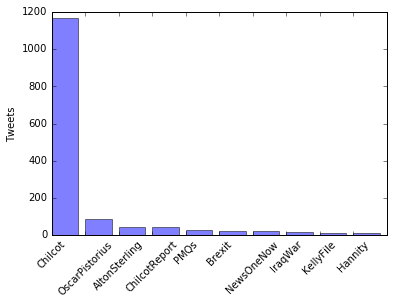

In [53]:
"""Plot top 10"""

most_common = Counter(hashtags).most_common(10)
most_common = [(key, value) for (key, value) in most_common]

# data to plot
labels, y = zip(*most_common)
x = range(len(labels))
    
# plot
plt.bar(x, y, alpha=0.5)
plt.xticks(x, labels, rotation='45')
plt.ylabel("Tweets")
plt.show()

In [54]:
"""Display an overview"""

tabulate(("Hashtags", "Unique"), [(len(hashtags), len(set(hashtags)))])

Hashtags | Unique 
 --- | --- 
1735 | 167 


## 4. Network Analysis

*A collection of computed datasets to create network visualisations using an external graphing tool such as [Gephi](https://gephi.org).*

In [ ]:
"""Setup for network analysis"""

from pymongo import MongoClient
from csv import writer
from time import time

# specify output folder
output_folder = "./analysis"

### 4.1. Mentions

This section aims to generate a collection of nodes and associated edges from a twitter mentions dataset. 

In [ ]:
"""Collect the data"""

start = time()

tweets = [tweet 
          for tweet in DB.tweets.find()]

# find all edges
edges = [(tweet["user"]["screen_name"], mention["screen_name"])
         for tweet in tweets[:]
             for mention in tweet["entities"]["user_mentions"]]

# generate nodes from edges
nodes = {node 
         for edge in edges 
             for node in edge}

print("Runtime: %.3fs" % (time() - start))

In [ ]:
"""Write nodes to CSV"""

node_file = "%s/mention_nodes.csv" % (output_folder)

# convert into csv format
nodes = [[node, node] 
         for node in nodes]

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [ ]:
"""Write edges to CSV"""

edge_file = "%s/mention_edges.csv" % (output_folder)

# convert into csv format
edges = [[nodes[0], nodes[1], weight] 
         for nodes, weight in Counter(edges).items()]

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target", "weight"])
    w.writerows(edges)

### 4.2. Replies

This section aims to generate a collection of nodes and associated edges from a twitter replies dataset. 

In [ ]:
"""Collect the data"""

start = time()

tweets = [t for t in DB.tweets.find()]
nodes = set()
edges = set()

# collect nodes
for tweet in tweets:
    source = tweet["user"]["id_str"]
    target = tweet["in_reply_to_user_id_str"]

    if target is not None:
        nodes.add((source, source))
        nodes.add((target, target))
        edges.add((source, target))
        
print("Runtime: %.3fs" % (time() - start))

In [ ]:
"""Write nodes to CSV"""

node_file = "%s/reply_nodes.csv" % (output_folder)

with open(node_file, 'w') as f:
    w = writer(f)
    w.writerow(["id", "label"])
    w.writerows(nodes)

In [ ]:
"""Write edges to CSV"""

edge_file = "%s/reply_edges.csv" % (output_folder)

with open(edge_file, 'w') as f:
    w = writer(f)
    w.writerow(["source", "target"])
    w.writerows(edges)

## 5. Sentiment Analysis

*An attempt to classify the sentiment of the collected data.*

In [55]:
"""Setup for sentiment analysis"""

from textblob import TextBlob

In [ ]:
def sentiment(tweets):
    """Get the number of positive, neutral and
    negative tweets in a sample."""
    
    polarity = [TextBlob(tweet["text"]).sentiment.polarity
                for tweet in tweets]

    positive = len([x 
                    for x in polarity
                         if x > 0])

    neutral = len([x 
                  for x in polarity
                      if x == 0])

    negative = len([x 
                   for x in polarity
                       if x < 0])
    
    return positive, neutral, negative

In [ ]:
def sent_pie(positive, neutral, negative):
    """Plot a pie chart"""
    
    sizes = (negative, neutral, positive)
    labels = ("Negative", "Neutral", "Positive")
    colors = ('lightcoral', 'gold', 'lightgreen')

    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
            shadow=True, startangle=90, explode=(0,0,0.1))

    plt.axis('equal')
    plt.show()

### 5.1. All Tweets

This section aims to produce statistics related to the sentiment of all tweets in the dataset.

In [56]:
"""Collect the data"""

positive, neutral, negative = sentiment(tweets=DB.tweets.find())

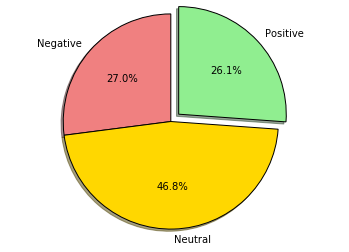

In [57]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)

## 5.1. Journalists

This section aims to produce statistics related to the sentiment of all original tweets authored by the journalists in the dataset. Please run the first cell of [section 3.1.](#3.1.-Original-Tweets) before attempting to run this section as it requires the `joi_originals` dataset in order to function as intended.

In [58]:
"""Collect the data"""

positive, neutral, negative = sentiment(joi_originals)

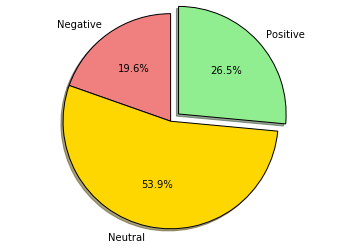

In [59]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)

## 5.2. Organisations

This section aims to produce statistics related to the sentiment of all original tweets authored by the organisations in the dataset. Please run the first cell of [section 3.1.](#3.1.-Original-Tweets) before attempting to run this section as it requires the `ooi_originals` dataset in order to function as intended.

In [60]:
"""Collect the data"""

positive, neutral, negative = sentiment(ooi_originals)

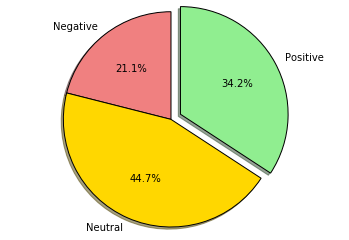

In [61]:
"""Plot a pie chart"""

sent_pie(positive, neutral, negative)